## Recommendation with MovieLens-100k

We introduce two approaches for movie rating recommendation using [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) and deep learning as introduced in [Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf). We use [MovieLens 100k](https://grouplens.org/datasets/movielens/100k/) (`ml-100k`) for our training and validation sets. We refer to [LibRec benchmarks](https://www.librec.net/release/v1.3/example.html) as public benchmarks.

## Imports

In [ ]:
# #uncomment if you are running from google colab
# !wget https://github.com/cstorm125/collab/archive/master.zip; unzip master
# !mv collab-master/images .
# !mv collab-master/data .
# !ls

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook
from copy import deepcopy

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = 'data/ml-100k/'

## Data Processing

There are 5 dataset pairs for training and validation of `ml-100k` dataset. We normalize the user and item index to start from 0 to comply with Python's style. The training set consists of 80,000 user-item-rating tuples and the validation set consists of 20,000 such tuples.

In [2]:
val_idx = 1 #which dataset pair to use
nb_users = 943 #total number of users
nb_items = 1682 #total number of items

In [3]:
train_df = pd.read_csv(f'{data_path}u{val_idx}.base',sep='\t',header=None)
train_df.columns = ['user_id','item_id','rating','ts']
train_df['user_id'] = train_df['user_id'] -1 #start index at 0
train_df['item_id'] = train_df['item_id'] -1
valid_df = pd.read_csv(f'{data_path}u{val_idx}.test',sep='\t',header=None)
valid_df.columns = ['user_id','item_id','rating','ts']
valid_df['user_id'] = valid_df['user_id'] -1 #start index at 0
valid_df['item_id'] = valid_df['item_id'] -1
train_df.shape, valid_df.shape

((80000, 4), (20000, 4))

We found that all users are in the training set so we should have no out-of-sample problem with the user embeddings.

In [4]:
#check number of unique users in both training and test set
train_users = train_df.user_id.unique()
valid_users = valid_df.user_id.unique()
len(train_users),len(valid_users)

(943, 459)

In [5]:
i = 0
for u in valid_users:
    if u in train_users: i+=1
i

459

However, we found that out of 1,410 items in the validation set only 1,378 items exist in the training set. This will affect when we predict ratings of those unseen items in the validation set.

In [6]:
train_items = train_df.item_id.unique()
valid_items = valid_df.item_id.unique()
len(train_items),len(valid_items)

(1650, 1410)

In [7]:
i = 0
for u in valid_items:
    if u in train_items: i+=1
i

1378

## Dataset

We create a Pytorch dataset object that returns the tuple of `(user,item,rating)` tensors based on the dataframe we read in. From those datasets, we can load data in batch by converting them to Pytorch dataloader objects. Here we set the batch size to 2000.

In [8]:
class CollabRatingDataset(Dataset):
    def __init__(self, df, user_col=0, item_col=1, rating_col=2):
        self.df = df
        self.user_tensor = torch.tensor(self.df.iloc[:,user_col], dtype=torch.long, device = device)
        self.item_tensor = torch.tensor(self.df.iloc[:,item_col], dtype=torch.long, device = device)
        self.target_tensor = torch.tensor(self.df.iloc[:,rating_col], dtype=torch.float32, device = device)
        
    def __getitem__(self, index):
        return(self.user_tensor[index], self.item_tensor[index], self.target_tensor[index])

    def __len__(self):
        return(self.user_tensor.shape[0])

In [9]:
bs = 2000
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)

In [10]:
len(train_ds),len(valid_ds),len(train_dl),len(valid_dl)

(80000, 20000, 40, 10)

In [11]:
train_ds[:3]

(tensor([0, 0, 0]), tensor([0, 1, 2]), tensor([5., 3., 4.]))

In [12]:
next(iter(train_dl))

[tensor([  1,  86, 548,  ...,  43, 248, 220]),
 tensor([283, 180, 150,  ..., 248, 180,  58]),
 tensor([4., 5., 3.,  ..., 4., 3., 2.])]

## Collaborative Filtering

Collaborative filtering is one of the most basic yet most powerful algorithm for recommendation. It is based on the premise that similar users will purchase similar items and vice versa. 

<img src='images/cf.gif'/>

### Architecture

The simplest form of collaborative filtering consists of the following elements:

1. **Item Embedding Layer** to convert item index to vectors
2. **User Embedding Layer** to convert user index to vectors
3. **Item Bias** to be added to the dot product
4. **User Bias** to be added to the dot product

We feed each pair of user and item indice into the layers above the perform the following operations to get the predicted rating:

$$rating_{predicted}=\sum{(E_{item} * E_{user})} + B_{user} + B_{item}$$

where $E$ stands for embedding activations and $B$ for biases.

In [89]:
class CollabNet(nn.Module):
    def __init__(self, config):
        super(CollabNet, self).__init__()
        #hyperparameters
        self.config = config
        self.nb_users = config['nb_users']
        self.nb_items = config['nb_items']
        self.emb_sz = config['emb_sz']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_sz)
        self.user_bias = nn.Embedding(num_embeddings=self.nb_users, embedding_dim=1)
        self.emb_item = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_sz)
        self.item_bias = nn.Embedding(num_embeddings=self.nb_items, embedding_dim=1)
        

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        dot = (user_emb * item_emb).sum(1)
        x = dot + self.user_bias(user_idx).squeeze() + self.item_bias(item_idx).squeeze()
        x = torch.sigmoid(x)
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [90]:
config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':100, #size of embedding vector
    'y_range': [0.8,5.2]} #range of output
model = CollabNet(config)
model

CollabNet(
  (emb_user): Embedding(943, 100)
  (user_bias): Embedding(943, 1)
  (emb_item): Embedding(1682, 100)
  (item_bias): Embedding(1682, 1)
)

### Training

In [91]:
#hyperparameters
bs = 2000 #batch size
lr = 5e-2 #learning rate
wd = 1e-1 #weight decay parameter
nb_epoch = 100 #how many epochs to train
reduce_lr = 1 #reduce learning rate if loss stagnates more than x epochs
early_stop = 2 #stop if validation loss doesnt improve for x epochs

config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':100, #size of embedding vector
    'y_range': [0.8,5.2]} #range of output

#recording
lrs = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)

#model
model = CollabNet(config)
crit = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-2,
                                                       patience=reduce_lr, min_lr=lr/10)

In [92]:
#training
for e in tqdm_notebook(range(nb_epoch)): 
    #train
    model.train()
    train_loss = 0
    for u,i,r in train_dl:
        #prediction
        r_pred = model(u,i)
        r = r.squeeze()
        
        #loss
        loss = crit(r_pred,r)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    #record
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)
    
    #valid
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dl:
        r_pred = model(u,i)
        r = r.squeeze()
        loss = crit(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_ds)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_lr}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements >= early_stop:
        print(f'early stopping after epoch {e}')
        break
    
    #step scheduler
    scheduler.step(valid_loss)

Epoch 0 Train loss: 5.247108984375; Valid loss: 4.87906435546875; Learning rate: 0.05
Epoch 1 Train loss: 3.874303039550781; Valid loss: 3.9522217041015626; Learning rate: 0.05
Epoch 2 Train loss: 2.8927701171875; Valid loss: 3.12446787109375; Learning rate: 0.05
Epoch 3 Train loss: 2.233895837402344; Valid loss: 2.6167475830078124; Learning rate: 0.05
Epoch 4 Train loss: 1.7319782623291016; Valid loss: 2.1589929443359375; Learning rate: 0.05
Epoch 5 Train loss: 1.2086614974975587; Valid loss: 1.6773607055664062; Learning rate: 0.05
Epoch 6 Train loss: 0.7006285461425781; Valid loss: 1.281966796875; Learning rate: 0.05
Epoch 7 Train loss: 0.38581652221679685; Valid loss: 1.0996696044921874; Learning rate: 0.05
Epoch 8 Train loss: 0.24723770370483397; Valid loss: 1.0499613891601562; Learning rate: 0.05
Epoch 9 Train loss: 0.18278679313659668; Valid loss: 1.0257831604003906; Learning rate: 0.05
Epoch 10 Train loss: 0.1540008144378662; Valid loss: 1.0201988037109375; Learning rate: 0.05
E

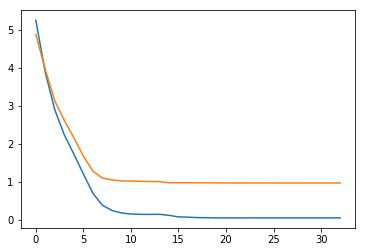

In [93]:
plt.plot(train_losses)
plt.plot(valid_losses)

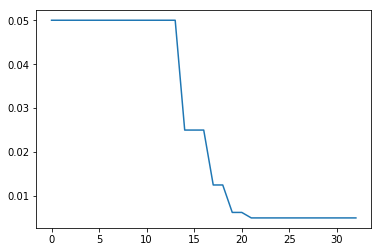

In [94]:
plt.plot(lrs)

In [95]:
print(f'Best RMSE: {np.sqrt(best_loss)}')

Best RMSE: 0.9845398361492763


### Item Embeddings

The useful thing about having item bias is that we can use it to rank our items, in this case, movies. Movies with more positive bias values are considered to be the "better" ones.

In [96]:
item_df = pd.read_csv(f'{data_path}u.item', delimiter='|', encoding='latin-1', header=None,
                    names=['item_id', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]])
item_df = item_df[['item_id','title']].copy()
item_df['item_id'] = item_df.item_id.map(lambda x: int(x)-1)
item_df.head()

,item_id,title
0,0,Toy Story (1995)
1,1,GoldenEye (1995)
2,2,Four Rooms (1995)
3,3,Get Shorty (1995)
4,4,Copycat (1995)


In [97]:
movie_ranking = []
for item_id in model.item_bias.weight.data.squeeze().argsort().cpu().numpy():
    movie_ranking.append((item_df.iloc[item_id,1],model.item_bias.weight.data[item_id].item()))

In [101]:
#best rated movies
movie_ranking[::-1][:10]

[("Schindler's List (1993)", 1.397660255432129),
 ('Shawshank Redemption, The (1994)', 1.3316079378128052),
 ('Usual Suspects, The (1995)', 1.321493148803711),
 ('Casablanca (1942)', 1.3207446336746216),
 ('Star Wars (1977)', 1.3201382160186768),
 ('Wrong Trousers, The (1993)', 1.2428542375564575),
 ('Raiders of the Lost Ark (1981)', 1.1953396797180176),
 ('Boot, Das (1981)', 1.1946910619735718),
 ('Titanic (1997)', 1.1681171655654907),
 ('Godfather, The (1972)', 1.1613645553588867)]

In [100]:
#worst rated movies
movie_ranking[:10]

[('Children of the Corn: The Gathering (1996)', -1.0702285766601562),
 ('Crow: City of Angels, The (1996)', -0.9223993420600891),
 ('Mortal Kombat: Annihilation (1997)', -0.8909540176391602),
 ('Bio-Dome (1996)', -0.8781499266624451),
 ('Island of Dr. Moreau, The (1996)', -0.8648573160171509),
 ("McHale's Navy (1997)", -0.8614532947540283),
 ('Leave It to Beaver (1997)', -0.814452052116394),
 ('Speed 2: Cruise Control (1997)', -0.8006588220596313),
 ("Joe's Apartment (1996)", -0.7971066236495972),
 ('Free Willy 3: The Rescue (1997)', -0.7965894937515259)]

## Deep Learning

### Architecture

The architecture as described in [Deep Neural Networks for YouTube Recommendations](https://static.googleusercontent.com/media/research.google.com/en//pubs/archive/45530.pdf) consists of two parts:
1. **Embedding Layers** to convert user and item indice to embedding vectors
2. **Fully-connected Layers** to take input of concatenated embedding vectors and output the rating

In [56]:
class ConcatNet(nn.Module):
    def __init__(self, config):
        super(ConcatNet, self).__init__()
        #hyperparameters
        self.config = config
        self.nb_users = config['nb_users']
        self.nb_items = config['nb_items']
        self.emb_sz = config['emb_sz']
        self.emb_p = config['emb_p']
        self.fc_sz = config['fc_sz']
        self.ps = config['ps']
        self.y_range = config['y_range']

        #embeddings
        self.emb_user = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_users, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))
        self.emb_item = nn.Sequential(
            nn.Embedding(num_embeddings=self.nb_items, embedding_dim=self.emb_sz),
            nn.Dropout(p=self.emb_p))

        #fully-connected layers
        fc_layers_list = []
        for ni,nf,p in zip(self.fc_sz[:-1], self.fc_sz[1:], self.ps):
            fc_layers_list.append(nn.Linear(ni, nf))
            fc_layers_list.append(nn.ReLU(inplace=True))
            fc_layers_list.append(nn.BatchNorm1d(nf))
            fc_layers_list.append(nn.Dropout(p=p))
        self.fc_layers = nn.Sequential(*fc_layers_list)

        #output head
        self.head = torch.nn.Linear(in_features=self.fc_sz[-1], out_features=1)

    def forward(self, user_idx, item_idx):
        user_emb = self.emb_user(user_idx)
        item_emb = self.emb_item(item_idx)
        x = torch.cat([user_emb, item_emb], dim=1)
        x = self.fc_layers(x)
        x = torch.sigmoid(self.head(x))
        x = x * (self.y_range[1] - self.y_range[0]) + self.y_range[0]
        return(x)

In [57]:
config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 512, 256], #size of fully-connected layers
    'ps': [0.7,0.35], #dropout for fully-connected layers
    'y_range': [0.8,5.2]} #range of output
model = ConcatNet(config)
model

ConcatNet(
  (emb_user): Sequential(
    (0): Embedding(943, 50)
    (1): Dropout(p=0.05)
  )
  (emb_item): Sequential(
    (0): Embedding(1682, 50)
    (1): Dropout(p=0.05)
  )
  (fc_layers): Sequential(
    (0): Linear(in_features=100, out_features=512, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.7)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.35)
  )
  (head): Linear(in_features=256, out_features=1, bias=True)
)

### Training

In [28]:
#hyperparameters
bs = 2000 #batch size
lr = 1e-2 #learning rate
wd = 5e-1 #weight decay parameter
nb_epoch = 100 #how many epochs to train
reduce_lr = 1 #reduce learning rate if loss stagnates more than x epochs
early_stop = 2 #stop if validation loss doesnt improve for x epochs

config = {
    'nb_users':943, #how many unique users
    'nb_items':1682, #how many unique items
    'emb_sz':50, #size of embedding vector
    'emb_p': 0.05, #dropout for embedding
    'fc_sz': [100, 512, 256], #size of fully-connected layers
    'ps': [0.7,0.35], #dropout for fully-connected layers
    'y_range': [0.8,5.2]} #range of output

#recording
lrs = []
train_losses=[]
valid_losses = []
best_loss = np.inf
best_weights = None

#datasets/loaders
train_ds = CollabRatingDataset(train_df)
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=4)
valid_ds = CollabRatingDataset(valid_df)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=4)

#model
model = ConcatNet(config)
crit = nn.MSELoss(reduction='sum')
optim = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9,0.999), weight_decay=wd)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optim, mode='min',factor=0.5, threshold=1e-3,
                                                       patience=reduce_lr, min_lr=lr/10)

In [68]:
#training
for e in tqdm_notebook(range(nb_epoch)): 
    #train
    model.train()
    train_loss = 0
    for u,i,r in train_dl:
        #prediction
        r_pred = model(u,i)
        r = r[:,None]
        
        #loss
        loss = crit(r_pred,r)
        
        #backprop
        optim.zero_grad()
        loss.backward()
        optim.step()
        train_loss+= loss.detach().item()
    #record
    current_lr = scheduler.optimizer.param_groups[0]['lr']
    lrs.append(current_lr)
    train_loss /= len(train_ds)
    train_losses.append(train_loss)
    
    #valid
    model.eval()
    valid_loss = 0
    for u,i,r in valid_dl:
        r_pred = model(u,i)
        r = r[:,None]
        loss = crit(r_pred,r)
        valid_loss+=loss.detach().item()
    valid_loss/=len(valid_ds)
    #record
    valid_losses.append(valid_loss)
    print(f'Epoch {e} Train loss: {train_loss}; Valid loss: {valid_loss}; Learning rate: {current_lr}')

    #choose best model
    if valid_loss < best_loss:
        best_loss = valid_loss
        best_weights = deepcopy(model.state_dict())
        no_improvements = 0
    else:
        no_improvements += 1

    #early stopping
    if no_improvements >= early_stop:
        print(f'early stopping after epoch {e}')
        break
    
    #step scheduler
    scheduler.step(valid_loss)

Epoch 0 Train loss: 1.2494271759033204; Valid loss: 1.16272138671875; Learning rate: 0.01
Epoch 1 Train loss: 1.0623522888183594; Valid loss: 1.0476969909667968; Learning rate: 0.01
Epoch 2 Train loss: 0.9629759887695313; Valid loss: 0.965164599609375; Learning rate: 0.01
Epoch 3 Train loss: 0.9165641418457031; Valid loss: 0.9421045227050782; Learning rate: 0.01
Epoch 4 Train loss: 0.8972671981811523; Valid loss: 0.9218044006347657; Learning rate: 0.01
Epoch 5 Train loss: 0.8800409591674805; Valid loss: 0.9142086181640625; Learning rate: 0.01
Epoch 6 Train loss: 0.8720957107543945; Valid loss: 0.9096045288085938; Learning rate: 0.01
Epoch 7 Train loss: 0.8633601898193359; Valid loss: 0.9045002868652344; Learning rate: 0.01
Epoch 8 Train loss: 0.8547678497314453; Valid loss: 0.8988922485351563; Learning rate: 0.01
Epoch 9 Train loss: 0.8445782485961915; Valid loss: 0.8834912292480469; Learning rate: 0.01
Epoch 10 Train loss: 0.8309583099365234; Valid loss: 0.8833601013183594; Learning r

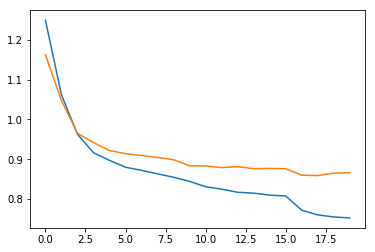

In [69]:
plt.plot(train_losses)
plt.plot(valid_losses)

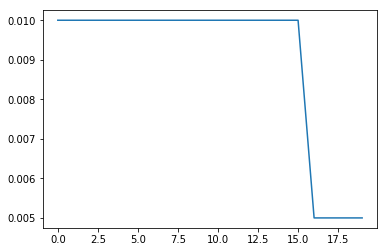

In [70]:
plt.plot(lrs)

In [71]:
print(f'Best RMSE: {np.sqrt(best_loss)}')

Best RMSE: 0.9268219262925541
